In [43]:
# from numpy import cov
import os
import pandas
import geopandas
from shapely.geometry import Point
import sys
import matplotlib
# from pytesmo.time_series.anomaly import calc_anomaly
# from pytesmo.time_series.anomaly import calc_anomaly
sys.path.append('../python')
sys.path.append('../../icos_data')
sys.path.append('../../ismn_data\HOBE_Data_2015-2018')
import sm_config as config
import sm_tools as tools
import sm_triplecollocation

In [44]:
def get_filenames(path_to_dir, suffix=".csv"):
    filenames = os.listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith(suffix) ]

In [45]:
# Index(['ref_dataset', 'eval_dataset', 'timefilter', 'anomaly', 'loc', 'lon',
#        'lat', 'veg_class', 'pearson_r', 'pearson_r_p-value', 'bias', 'rmsd',
#        'ubrmsd', 'n', 'pearson_sig'],
def get_plot(dataframe, metric_col, plot_name, sig=None, anomaly=True, timefilter="all", veg_class_filter=None, lon_field="lon", lat_field="lat"):
    plot = ""
    return plot
    

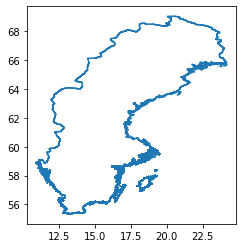

In [46]:
# world_filepath = geopandas.datasets.get_path('naturalearth_lowres')
# world = geopandas.read_file(world_filepath)
# world.head()
# sweden = world.loc[world['name'] == 'Sweden'] # get Sweden row
# boundaries = sweden['geometry'] # get Sweden geometry
# sweden.head()
# sweden.boundary.plot()

sweden = geopandas.read_file(r"../basemap/SWE_adm0.shp")
sweden.boundary.plot()


In [47]:
map_output_dir = r"../analysis_output/grid_evaluation_maps"
if not os.path.exists(map_output_dir):
    os.mkdir(map_output_dir)

In [48]:
# import pandas as pd
# import geopandas
# from shapely.geometry import Point
# import matplotlib.pyplot as plt

# df = pd.read_csv('name.csv')

# geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

# gdf = geopandas.GeoDataFrame(df, geometry=geometry)

# gdf.plot(column=' Ref')

# plt.savefig('raster.tiff')

In [49]:
# "C:\git\soil-moisture-sweden\analysis_output\ERA5 0-1 grid evaluation 20210407124502"
grid_metrics_dir = r"../analysis_output/ERA5 0-1 grid evaluation 20210407124502"
print(grid_metrics_dir)
os.getcwd()
os.listdir(grid_metrics_dir)

../analysis_output/ERA5 0-1 grid evaluation 20210407124502


['ASCAT 12.5 TS ERA5 0-1 absolute',
 'ASCAT 12.5 TS ERA5 0-1 anomaly',
 'ASCAT 12.5 TS metrics.csv',
 'CCI Active ERA5 0-1 absolute',
 'CCI Active ERA5 0-1 anomaly',
 'CCI Active metrics.csv',
 'CCI Combined ERA5 0-1 absolute',
 'CCI Combined ERA5 0-1 anomaly',
 'CCI Combined metrics.csv',
 'CCI Passive ERA5 0-1 absolute',
 'CCI Passive ERA5 0-1 anomaly',
 'CCI Passive metrics.csv',
 'GLDAS ERA5 0-1 absolute',
 'GLDAS ERA5 0-1 anomaly',
 'GLDAS metrics.csv',
 'Sentinel-1 ERA5 0-1 absolute',
 'Sentinel-1 ERA5 0-1 anomaly',
 'Sentinel-1 metrics.csv',
 'SMAP L3 Enhanced ERA5 0-1 absolute',
 'SMAP L3 Enhanced ERA5 0-1 anomaly',
 'SMAP L3 Enhanced metrics.csv',
 'SMAP L3 ERA5 0-1 absolute',
 'SMAP L3 ERA5 0-1 anomaly',
 'SMAP L3 metrics.csv',
 'SMAP L4 ERA5 0-1 absolute',
 'SMAP L4 ERA5 0-1 anomaly',
 'SMAP L4 metrics.csv',
 'SMOS-BEC ERA5 0-1 absolute',
 'SMOS-BEC ERA5 0-1 anomaly',
 'SMOS-BEC metrics.csv',
 'SMOS-IC ERA5 0-1 absolute',
 'SMOS-IC ERA5 0-1 anomaly',
 'SMOS-IC metrics.csv']

In [50]:
grid_metrics_csvs = get_filenames(grid_metrics_dir)
print(grid_metrics_csvs)

['ASCAT 12.5 TS metrics.csv', 'CCI Active metrics.csv', 'CCI Combined metrics.csv', 'CCI Passive metrics.csv', 'GLDAS metrics.csv', 'Sentinel-1 metrics.csv', 'SMAP L3 Enhanced metrics.csv', 'SMAP L3 metrics.csv', 'SMAP L4 metrics.csv', 'SMOS-BEC metrics.csv', 'SMOS-IC metrics.csv']


In [ ]:
for fn in grid_metrics_csvs:
    pn = fn.replace(" metrics.csv", "")
#     print(pn)
    pn_dir = os.path.join(map_output_dir, pn)
    if not os.path.exists(pn_dir):
        os.mkdir(pn_dir)
    f = os.path.join(grid_metrics_dir, fn)
    df = pandas.read_csv(f)
#     print(df)
#     print(df.columns)
#     print([df.timefilter.unique()])
    # filter df by timefilter values
    # filter out insignificant and non-anomaly rows
    df_sub = df[(df.pearson_sig == True) & (df.anomaly == True)]
    for timefilter in df.timefilter.unique():
#         if timefilter == "No-Timefilter":
        if timefilter != "all" and "M" not in timefilter:
            tf_dir = os.path.join(map_output_dir, timefilter)
            if not os.path.exists(tf_dir):
                os.mkdir(tf_dir)
            df_tf = df_sub[df.timefilter == timefilter]
#             print(df_tf.head)
#             print(df_tf)
#             print(timefilter)
#             print(df_tf.shape)
            # create and output map
        # lon = col 5, lat = col 6
            base = sweden.plot(color='white', edgecolor='silver')
            geometry = [Point(xy) for xy in zip(df_tf.iloc[:, 5], df_tf.iloc[:, 6])]
            gdf = geopandas.GeoDataFrame(df_tf, geometry=geometry)
#             gdf.title("{} {}".format(pn, timefilter))
#legend_kwds={'label': "Population by Country",
#   ....:                         'orientation': "horizontal"})
            gdf.plot(ax=base, column='pearson_r', legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
#             gdf.plot(column='pearson_r', legend=True, legend_kwds={'label': " R (p < 0.05)"}, figsize=(6,6))
#             matplotlib.pyplot.figure(tight_layout=True)    
#             matplotlib.axes.Axes.set_xlim(left=8, right=25)
#             matplotlib.axes.Axes.set_ylim(bottom=54, top=69)            
            matplotlib.pyplot.suptitle("{} x ERA5 ({})".format(pn, timefilter))
            matplotlib.pyplot.savefig(os.path.join(tf_dir, "{} {}.jpg".format(pn, timefilter)))
            matplotlib.pyplot.savefig(os.path.join(pn_dir, "{} {}.jpg".format(pn, timefilter)))
#             if timefilter == "No-Timefilter":
#                 for veg_class in df.veg_class.unique():
#                     if veg_class not in config.ignore_veg_classes:
#                         df_vc = df_tf[df_tf.veg_class == veg_class]
#                         print(veg_class)
#                         print(df_vc.shape)
                        # create and output map
#     print(df.timefilter.unique()) 
#     print(df)
#     geometry = [Point(xy) for xy in zip(df.iloc[:, 0], df.iloc[:, 1])]

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipy

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\ProgramData\Anaconda3\envs\sm_win\lib\site-packages\geopandas\plotting.py:503: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control 

In [ ]:
# lon = col 5, lat = col 6
geometry = [Point(xy) for xy in zip(df.iloc[:, 5], df.iloc[:, 6])]
gdf = geopandas.GeoDataFrame(df, geometry=geometry)
gdf.plot(column='pearson_r', legend=True)

In [ ]:
# import os
# import gdal

# dir_with_csvs = r"/home/panda"
# os.chdir(dir_with_csvs)

# def find_csv_filenames(path_to_dir, suffix=".csv"):
#     filenames = os.listdir(path_to_dir)
#     return [ filename for filename in filenames if filename.endswith(suffix) ]
# csvfiles = find_csv_filenames(dir_with_csvs)
# for fn in csvfiles:
#     vrt_fn = fn.replace(".csv", ".vrt")
#     lyr_name = fn.replace('.csv', '')
#     out_tif = fn.replace('.csv', '.tiff')
#     with open(vrt_fn, 'w') as fn_vrt:
#         fn_vrt.write('<OGRVRTDataSource>\n')
#         fn_vrt.write('\t<OGRVRTLayer name="%s">\n' % lyr_name)
#         fn_vrt.write('\t\t<SrcDataSource>%s</SrcDataSource>\n' % fn)
#         fn_vrt.write('\t\t<GeometryType>wkbPoint</GeometryType>\n')
#         fn_vrt.write('\t\t<GeometryField encoding="PointFromColumns" x="Lon" y="Lat" z="Ref"/>\n')
#         fn_vrt.write('\t</OGRVRTLayer>\n')
#         fn_vrt.write('</OGRVRTDataSource>\n')

# output = gdal.Grid('outcome.tif','name.vrt')
# # below using your settings - I don't have sample large enough to properly test it, but it is generating file as well  
# output2 = gdal.Grid('outcome2.tif','name.vrt', algorithm='invdist:power=2.0:smoothing=1.0')  